In [1]:
import pandas as pd
import numpy as np
import requests
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import wget

from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
from geopy.geocoders import Nominatim

In [2]:
dfs = pd.read_html('http://www.geonames.org/postalcode-search.html?q=&country=IE')
dftemp = pd.DataFrame(data=dfs[2])
dftemp.drop(columns=['Unnamed: 0','Country', 'Admin1', 'Admin2', 'Admin3'], inplace=True)
df = dftemp.iloc[::2]
dflatlon = dftemp.iloc[1::2]
dflatlon.drop(columns=['Code'])
dflatlon = dflatlon["Place"].str.split("/", n = 1, expand = True)
dflatlon.rename(columns={0:"Latitude", 1:"Longitude"}, inplace=True)
df.reset_index(drop=True, inplace=True)
dflatlon.reset_index(drop=True, inplace=True)
df = df.merge(dflatlon, left_index=True, right_index=True)
bool_series = df["Code"].str.startswith("D", na = False)
df = df[bool_series]
df.reset_index(drop=True, inplace=True)
df = df.astype({"Latitude": float, "Longitude": float})
df.rename(columns={'Place': 'Postal Code'}, inplace=True)
df.drop(columns=['Code'], inplace=True)

In [3]:
df1 = pd.read_csv("ppr-2017-2019-dublin.csv", encoding='unicode_escape')

In [4]:
df1.drop(df1.columns.difference(['Postal Code', 'Price ()']), 1, inplace=True)
df1.rename(columns={'Price ()':'Price'}, inplace=True)
df1['Price'] = df1['Price'].replace({'\': '', ',': ''}, regex=True).astype(float)
df1.dropna(inplace=True)
df1 = df1.groupby('Postal Code', as_index=False).mean()

In [5]:
df1

,Postal Code,Price
0,Baile Átha Cliath 18,440000.000000
1,Dublin 1,486721.642807
2,Dublin 10,187167.754513
3,Dublin 11,275492.545148
4,Dublin 12,321935.054164
5,Dublin 13,391350.850620
6,Dublin 14,599890.718144
7,Dublin 15,343489.276409
8,Dublin 16,469078.535381
9,Dublin 17,348814.927377


In [6]:
df1.at[19, 'Postal Code'] = 'Dublin 6W'

In [7]:
dublin_data = pd.concat([df.set_index('Postal Code'),df1.set_index('Postal Code')], axis=1, join='inner').reset_index()
dublin_data['Price'] = dublin_data['Price'].apply(lambda x: '%.2f' % x)

In [8]:
address = "O'Connell Bridge, Dublin, Ireland"

geolocator = Nominatim(user_agent="ie_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("The geographical coordinate of O'Connel Bridge are {}, {}.".format(latitude, longitude))

The geographical coordinate of O'Connel Bridge are 53.347265500000006, -6.259104274441249.


In [9]:
map_dublin = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, pcode in zip(dublin_data['Latitude'], dublin_data['Longitude'], dublin_data['Postal Code']):
    label = '{}'.format(pcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dublin)  
    
map_dublin

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
LIMIT = 200

dublin_venues = getNearbyVenues(names=dublin_data['Postal Code'],
                                   latitudes=dublin_data['Latitude'],
                                   longitudes=dublin_data['Longitude']
                                  )

Dublin 1
Dublin 2
Dublin 3
Dublin 4
Dublin 5
Dublin 6
Dublin 7
Dublin 8
Dublin 9
Dublin 10
Dublin 11
Dublin 12
Dublin 13
Dublin 14
Dublin 15
Dublin 16
Dublin 17
Dublin 18
Dublin 20
Dublin 22
Dublin 24
Dublin 6W


In [13]:
dublin_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Dublin 1,53.354,-6.255,147 Deli,53.353410,-6.259807,Deli / Bodega
1,Dublin 1,53.354,-6.255,The Celt,53.350442,-6.255071,Pub
2,Dublin 1,53.354,-6.255,"Laine, my love",53.351320,-6.251253,Café
3,Dublin 1,53.354,-6.255,Il Capo,53.351193,-6.251792,Italian Restaurant
4,Dublin 1,53.354,-6.255,El Grito Mexican Taqueria,53.357390,-6.256618,Mexican Restaurant


In [14]:
dublin_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Dublin 1,68,68,68,68,68,68
Dublin 10,4,4,4,4,4,4
Dublin 11,8,8,8,8,8,8
Dublin 12,15,15,15,15,15,15
Dublin 13,5,5,5,5,5,5
Dublin 14,10,10,10,10,10,10
Dublin 15,6,6,6,6,6,6
Dublin 16,95,95,95,95,95,95
Dublin 17,7,7,7,7,7,7


In [15]:
print('There are {} uniques categories.'.format(len(dublin_venues['Venue Category'].unique())))

There are 137 uniques categories.


In [16]:
# one hot encoding
dublin_onehot = pd.get_dummies(dublin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dublin_onehot['Neighborhood'] = dublin_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dublin_onehot.columns[-1]] + list(dublin_onehot.columns[:-1])
dublin_onehot = dublin_onehot[fixed_columns]

dublin_onehot.head()

,Neighborhood,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,...,Toy / Game Store,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Dublin 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Dublin 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Dublin 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Dublin 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dublin 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
dublin_onehot.shape

(638, 138)

In [18]:
dublin_grouped = dublin_onehot.groupby('Neighborhood').mean().reset_index()
dublin_grouped

,Neighborhood,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,...,Toy / Game Store,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Dublin 1,0.000000,0.000000,0.014706,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.029412,0.000000,0.000000,0.014706,0.000000,0.000000,0.00
1,Dublin 10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2,Dublin 11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,Dublin 12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,Dublin 13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,...,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,Dublin 14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,Dublin 15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
7,Dublin 16,0.010526,0.000000,0.000000,0.000000,0.010526,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.010526,0.000000,0.010526,0.010526,0.021053,0.000000,0.000000,0.00
8,Dublin 17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
9,Dublin 18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.00


In [19]:
dublin_grouped.shape

(22, 138)

In [20]:
num_top_venues = 5

for hood in dublin_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = dublin_grouped[dublin_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Dublin 1----
                venue  freq
0                 Pub  0.09
1         Coffee Shop  0.06
2  Italian Restaurant  0.04
3             Theater  0.04
4               Hotel  0.04


----Dublin 10----
                venue  freq
0                 Bar  0.50
1  Chinese Restaurant  0.25
2       Grocery Store  0.25
3              Arcade  0.00
4   Outdoor Sculpture  0.00


----Dublin 11----
                  venue  freq
0  Fast Food Restaurant  0.25
1            Hobby Shop  0.12
2           Pizza Place  0.12
3           Supermarket  0.12
4         Grocery Store  0.12


----Dublin 12----
          venue  freq
0   Coffee Shop  0.13
1          Park  0.13
2          Café  0.13
3   Supermarket  0.07
4  Betting Shop  0.07


----Dublin 13----
             venue  freq
0  Badminton Court   0.2
1      Auto Garage   0.2
2     Soccer Field   0.2
3    Train Station   0.2
4      Supermarket   0.2


----Dublin 14----
                    venue  freq
0             Supermarket   0.3
1  Furniture / Home S

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dublin_grouped['Neighborhood']

for ind in np.arange(dublin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dublin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dublin 1,Pub,Coffee Shop,Theater,Hotel,Italian Restaurant,Convenience Store,Turkish Restaurant,Gastropub,Bar,Clothing Store
1,Dublin 10,Bar,Grocery Store,Chinese Restaurant,Yoga Studio,Department Store,Eastern European Restaurant,Donut Shop,Discount Store,Diner,Dessert Shop
2,Dublin 11,Fast Food Restaurant,Grocery Store,Pizza Place,Hobby Shop,Supermarket,Electronics Store,Department Store,Yoga Studio,Dessert Shop,Donut Shop
3,Dublin 12,Park,Coffee Shop,Café,Chinese Restaurant,Supermarket,Fast Food Restaurant,Pub,Shopping Mall,Bistro,Betting Shop
4,Dublin 13,Auto Garage,Soccer Field,Supermarket,Train Station,Badminton Court,Dessert Shop,Eastern European Restaurant,Donut Shop,Discount Store,Diner


In [23]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,22) 

dublin_grouped_clustering = dublin_grouped.drop('Neighborhood', 1)

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(dublin_grouped_clustering)
    kmeanModel.fit(dublin_grouped_clustering)  
      
    distortions.append(sum(np.min(cdist(dublin_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / dublin_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(dublin_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / dublin_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

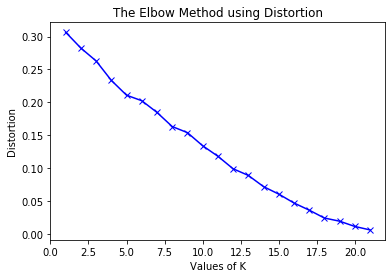

In [24]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [25]:
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val))

1 : 2.340673115602629
2 : 1.9238093043673723
3 : 1.7137695600652156
4 : 1.5132902475745837
5 : 1.2351942454398814
6 : 1.1176991690764182
7 : 0.9484568474597385
8 : 0.757292577337336
9 : 0.665378041949023
10 : 0.5744830209535026
11 : 0.47479774185878254
12 : 0.37951276589074273
13 : 0.31205566552895264
14 : 0.24205566552895263
15 : 0.18575936923265635
16 : 0.14134868043306034
17 : 0.09270128375254846
18 : 0.05779004114899816
19 : 0.03688595175032283
20 : 0.02135535264411842
21 : 0.009387534626038783


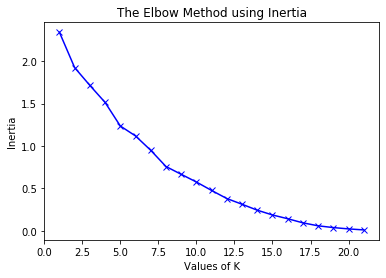

In [26]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [27]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dublin 1,Pub,Coffee Shop,Theater,Hotel,Italian Restaurant,Convenience Store,Turkish Restaurant,Gastropub,Bar,Clothing Store
1,Dublin 10,Bar,Grocery Store,Chinese Restaurant,Yoga Studio,Department Store,Eastern European Restaurant,Donut Shop,Discount Store,Diner,Dessert Shop
2,Dublin 11,Fast Food Restaurant,Grocery Store,Pizza Place,Hobby Shop,Supermarket,Electronics Store,Department Store,Yoga Studio,Dessert Shop,Donut Shop
3,Dublin 12,Park,Coffee Shop,Café,Chinese Restaurant,Supermarket,Fast Food Restaurant,Pub,Shopping Mall,Bistro,Betting Shop
4,Dublin 13,Auto Garage,Soccer Field,Supermarket,Train Station,Badminton Court,Dessert Shop,Eastern European Restaurant,Donut Shop,Discount Store,Diner
5,Dublin 14,Supermarket,Furniture / Home Store,Hardware Store,Pub,Restaurant,Café,Gym,Athletics & Sports,Fast Food Restaurant,Concert Hall
6,Dublin 15,Platform,Pub,Fish & Chips Shop,Train Station,Bus Stop,Concert Hall,Construction & Landscaping,Convenience Store,College Library,Electronics Store
7,Dublin 16,Pub,Café,Bar,Coffee Shop,Hotel,Restaurant,Brewery,Historic Site,Fish & Chips Shop,Theater
8,Dublin 17,Park,Sports Club,Chinese Restaurant,Business Service,Convenience Store,Pharmacy,Dessert Shop,Eastern European Restaurant,Donut Shop,Discount Store
9,Dublin 18,Fast Food Restaurant,Furniture / Home Store,Electronics Store,Coffee Shop,Shopping Mall,Hardware Store,Wine Shop,Gift Shop,Donut Shop,College Library


In [28]:
dublin_data.rename(columns={'Postal Code':'Neighborhood'}, inplace=True)
dublin_merged = dublin_data
dublin_merged = dublin_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
dublin_merged = dublin_merged.astype({"Price": float})

Dublin 22 has the lowest real estate price and a pharmacy doesn't appear in the top 10 venues, so if an investor is considering to open a pharmacy in that neighborhood, this analysis indicates that they shoul proceed with the business analysis evaluating other factors that may impact the final business decision.

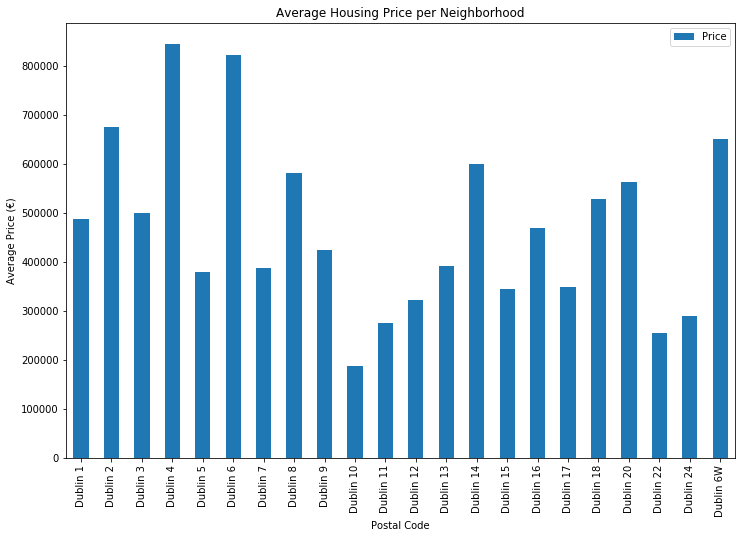

In [29]:
dublin_merged.plot(x='Neighborhood', y='Price', kind='bar', figsize=(12,8))
plt.xlabel('Postal Code')
plt.ylabel('Average Price (€)')
plt.title('Average Housing Price per Neighborhood')
plt.show()

In [30]:
map_dublin = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neigh, avg_price, v1, v2, v3 in zip(dublin_merged['Latitude'], dublin_merged['Longitude'], dublin_merged['Neighborhood'], dublin_merged['Price'], dublin_merged['1st Most Common Venue'], dublin_merged['2nd Most Common Venue'], dublin_merged['3rd Most Common Venue']):
    label = '{}, Avg Housing Price = {} \n {}, {}, {}'.format(neigh, avg_price, v1, v2, v3)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dublin)  
    
map_dublin

In [31]:
dublin_merged

,Neighborhood,Latitude,Longitude,Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dublin 1,53.354,-6.255,486721.64,Pub,Coffee Shop,Theater,Hotel,Italian Restaurant,Convenience Store,Turkish Restaurant,Gastropub,Bar,Clothing Store
1,Dublin 2,53.340,-6.254,675337.04,Coffee Shop,Pub,Café,Hotel,Park,Cocktail Bar,Bookstore,Bakery,Restaurant,Grocery Store
2,Dublin 3,53.364,-6.238,500257.17,Grocery Store,Pub,Café,Park,Bus Stop,Gym,Fried Chicken Joint,Indian Restaurant,Japanese Restaurant,Music Venue
3,Dublin 4,53.333,-6.234,844625.68,Pub,Café,Hotel,Pizza Place,Coffee Shop,Thai Restaurant,Indian Restaurant,Italian Restaurant,Bar,Sandwich Place
4,Dublin 5,53.384,-6.192,379007.14,Grocery Store,Pharmacy,Italian Restaurant,Train Station,Department Store,Eastern European Restaurant,Donut Shop,Discount Store,Diner,Dessert Shop
5,Dublin 6,53.309,-6.263,822544.62,Park,Gym / Fitness Center,Golf Course,Diner,Betting Shop,Tram Station,Pub,Fish Market,Bus Stop,Sculpture Garden
6,Dublin 7,53.362,-6.292,388225.80,Supermarket,Shopping Mall,Pub,Wine Shop,Gym Pool,Gift Shop,Pizza Place,Gas Station,Grocery Store,Food Court
7,Dublin 8,53.335,-6.273,580766.37,Café,Pub,Coffee Shop,Restaurant,Hotel,Fried Chicken Joint,Burger Joint,Pizza Place,Italian Restaurant,Bakery
8,Dublin 9,53.382,-6.247,423167.53,Grocery Store,Pub,Soccer Field,Fast Food Restaurant,Betting Shop,Convenience Store,Hotel,Café,Asian Restaurant,Chinese Restaurant
9,Dublin 10,53.341,-6.354,187167.75,Bar,Grocery Store,Chinese Restaurant,Yoga Studio,Department Store,Eastern European Restaurant,Donut Shop,Discount Store,Diner,Dessert Shop
